In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob

import stan_utils as stan
from mpl_utils import (mpl_style, common_limits)

plt.style.use(mpl_style)

np.random.seed(42)

%matplotlib inline

In [2]:
survey_data_paths = glob("data/*.csv")
survey_data = [Table.read(dp) for dp in survey_data_paths]

In [3]:
for dp, d in zip(survey_data_paths, survey_data):
    print(dp, d.dtype.names)

data/Adibekyan12-all-renorm.csv ('HIP', 'Star', 'Teff', 'logg', 'FeH', 'NaH', 'MgH', 'AlH', 'SiH', 'CaH', 'ScIH', 'ScIIH', 'TiIH', 'TiIIH', 'VH', 'CrIH', 'CrIIH', 'MnH', 'CoH', 'NiH')
data/Bensby14-all-renorm.csv ('HIP', 'Teff', 'logg', 'FeH', 'OH', 'NaH', 'MgH', 'AlH', 'SiH', 'CaH', 'TiH', 'CrH', 'NiH', 'ZnH', 'YH', 'BaH')
data/Valenti05-all-renorm.csv ('HIP', 'HD', 'Teff', 'logg', 'NaH', 'SiH', 'TiH', 'FeH', 'NiH')


In [4]:
label_identifier = "HIP"
label_names = ("Teff", "logg", "FeH", "SiH")
latex_label_names = [
    r"$T_{\rm eff}$",
    r"$\log{g}$",
    r"\textrm{[Fe/H]}",
    r"\textrm{[Si/H]}",
]

In [5]:
# generate the data arrays
unique_hip_names = np.sort(np.unique(np.hstack([d["HIP"] for d in survey_data])))
N = unique_hip_names.size
M = len(survey_data)
D = len(label_names)

y = np.nan * np.ones((N, M, D), dtype=float)

In [6]:
for m, data in enumerate(survey_data):
    for i, star in enumerate(data):
        n = np.where(star[label_identifier] == unique_hip_names)[0][0]
        y[n, m, :] = np.array([(star[ln] if ln in star.dtype.names else np.nan) \
                               for ln in label_names])
        

In [7]:
# set bad abundances as nans
for d, label_name in enumerate(label_names):
    if label_name not in ("Teff", "logg"):
        y[:, :, d][(y[:, :, d] >= 90)] = np.nan


In [8]:
# Only use stars that are common to all surveys
y
y.shape

(2237, 3, 4)

In [9]:
y.reshape((N, -1))

array([[ 5.185e+03,  4.440e+00, -3.000e-02, ...,        nan,        nan,
               nan],
       [ 5.894e+03,  4.360e+00, -5.300e-01, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [ 6.158e+03,  4.670e+00, -1.000e-02, ...,        nan,        nan,
               nan],
       [ 5.436e+03,  4.390e+00, -2.000e-01, ...,        nan,        nan,
               nan],
       [ 5.504e+03,  4.470e+00, -4.000e-01, ...,        nan,        nan,
               nan]])

In [11]:
keep = np.all(np.isfinite(y.reshape((N, -1))), axis=1)

y = y[keep]
N = sum(keep)
print("There are {0} stars in common between the {1} surveys".format(N, M))

There are 61 stars in common between the 3 surveys


In [12]:
# checks
for d, label_name in enumerate(label_names):
    _ = y[:, :, d]
    print("{0}: ({1:.1f} to {2:.1f}), mean/median/std: {3:.1f}/{4:.1f}/{5:.1f} ({6:.0f} finite)".format(
          label_name, np.nanmin(_), np.nanmax(_), 
          np.nanmean(_), np.nanmedian(_), np.nanstd(_),
          np.sum(np.isfinite(_))))

Teff: (4796.0 to 6459.0), mean/median/std: 5716.8/5720.0/281.8 (183 finite)
logg: (3.8 to 4.8), mean/median/std: 4.4/4.4/0.2 (183 finite)
FeH: (-1.4 to 0.4), mean/median/std: -0.1/0.0/0.4 (183 finite)
SiH: (-1.4 to 0.4), mean/median/std: -0.0/0.0/0.3 (183 finite)


In [15]:
model = stan.read_model("model-joint-survey-variance.stan")
print(model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3027715db59ab3585a525c4b11c09b69 NOW.



/*
   Latent factor model for chemical abundances from multiple studies.

   This model assumes no missing data, complete overlapm between studies,
   and that the label variance on each survey is the same.
*/

data {
  int<lower=1> N; // number of stars
  int<lower=1> D; // dimensionality of the data (number of labels)
  int<lower=1> M; // number of surveys (or studies)
  vector[D] y[N, M]; // the labels as reported by various surveys.
  vector<lower=0>[D] scales; // fixed relative scales for latent factors
}

transformed data {
  vector[D] mu; // the mean of the data in each dimension
  int<lower=1> Q; // the number of non-zero lower-triangular entries that we
                  // need for the decomposoition of our theta matrix
  Q = M * choose(D, 2);

  // TODO: Stop assuming that the user is not an idiot
  mu = rep_vector(0.0, D);
}

parameters {
  vector[D] X[N]; // latent factors for each star
  vector<lower=0>[D] phi; // variance on survey labels

  vector[Q] L_lower_triangular

In [16]:
# Optimize the model.
mu = np.mean(y.reshape((-1, D)), axis=0)
scales = np.std(y.reshape((-1, D)), axis=0)

print("\mu: {}".format(mu))
print("\sigma: {}".format(scales))

# TODO: HANDLE THE SCALES IN A BETTER WAY
data = dict(N=N, M=M, D=D, scales=np.ones(D), 
            y=(y - mu)/scales)

op_kwds = dict(
    data=data, 
    iter=100000, 
    tol_obj=7./3 - 4./3 - 1, # machine precision
    tol_grad=7./3 - 4./3 - 1, # machine precision
    tol_rel_grad=1e3,
    tol_rel_obj=1e4
)

\mu: [ 5.71680874e+03  4.36852459e+00 -9.57923497e-02 -7.33879781e-03]
\sigma: [2.81760006e+02 1.68320239e-01 3.54327348e-01 2.56743467e-01]


In [17]:
p_opt = model.optimizing(**op_kwds)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [18]:
print(p_opt)

OrderedDict([('X', array([[ 0.74837142,  0.10658038, -0.44435334, -0.11684608],
       [ 0.98515135, -0.83204596, -0.5558818 , -0.36944677],
       [-0.27592537,  0.30527967, -0.2579141 , -0.19578148],
       [-0.04757783,  0.32783521, -0.43573185, -0.18229397],
       [ 1.27135107,  0.17542502, -0.25803832, -0.04859665],
       [ 0.19019665,  0.08834077, -0.31114018, -0.09987128],
       [ 0.03744002,  0.17386499, -0.32719987, -0.04963057],
       [ 0.0848296 , -0.98831297,  0.50372721,  0.18220717],
       [ 0.24617674, -0.69344957,  0.44295302,  0.06262892],
       [ 1.23935209,  0.63957739,  0.08718781,  0.20928564],
       [-0.48644677,  0.31730559, -0.55197837, -0.44161382],
       [ 1.41896818,  0.15938263,  0.16680936,  0.26143593],
       [ 0.45076048,  0.36761586, -0.45633141, -0.1173405 ],
       [-0.71911834,  0.56623346, -0.42909646, -0.18760784],
       [ 0.95526742,  0.46653067, -1.7301779 , -0.88858557],
       [-1.7734295 , -1.65888367,  1.24684115, -0.15037946],
     

In [19]:
print(p_opt["X"].shape)
print(p_opt["theta"].shape)
print(N, M, D)

(61, 4)
(3, 4, 4)
61 3 4


In [20]:
np.dot(p_opt["X"], p_opt["theta"][0]) * scales + mu

array([[ 5.94275537e+03,  4.41834052e+00, -1.88515225e-01,
        -8.69367851e-02],
       [ 5.95535679e+03,  4.24786720e+00, -2.49843044e-01,
        -1.24607935e-01],
       [ 5.58543153e+03,  4.43468574e+00, -2.73860447e-01,
        -1.85351255e-01],
       [ 5.65098948e+03,  4.44389427e+00, -3.15753045e-01,
        -1.84577748e-01],
       [ 6.17165129e+03,  4.44609920e+00, -1.04890829e-02,
        -1.56643802e-02],
       [ 5.74849275e+03,  4.39699404e+00, -2.16237998e-01,
        -9.04423532e-02],
       [ 5.69576163e+03,  4.40618069e+00, -2.40449096e-01,
        -8.01554242e-02],
       [ 5.77047355e+03,  4.15783832e+00,  1.47477536e-01,
         2.49379124e-01],
       [ 5.83316379e+03,  4.23212624e+00,  1.37873134e-01,
         1.52616521e-01],
       [ 6.24159652e+03,  4.52640471e+00,  1.80686948e-01,
         1.06199787e-01],
       [ 5.45607497e+03,  4.44523948e+00, -4.69675669e-01,
        -3.59456358e-01],
       [ 6.29704095e+03,  4.42940662e+00,  2.41976989e-01,
      

(3, 4, 4)


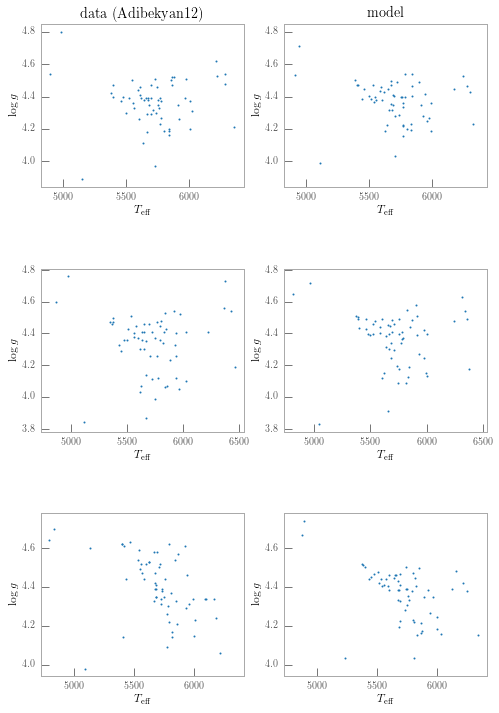

In [21]:
#  Plot model predictions compared to the data.

print(p_opt["theta"].shape)

xi, yi = range(2) # indices to plot.

fig, axes = plt.subplots(M, 2, figsize=(4 * 2, 4 * M))
axes = np.array(axes)

for m in range(M):
    ax_data, ax_model = axes[m]
    
    ax_data.scatter(y[:, m, xi],
                    y[:, m, yi],
                    s=1)
    
    y_tilde = np.dot(p_opt["X"], p_opt["theta"][m]) * scales + mu
    ax_model.scatter(y_tilde[:, xi],
                     y_tilde[:, yi],
                     s=1)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    
    for ax in (ax_data, ax_model):
        ax.set_xlabel(latex_label_names[xi])
        ax.set_ylabel(latex_label_names[yi])
    
    if ax.is_first_row():
        ax_model.set_title(r"\textrm{model}")
        ax_data.set_title(r"\textrm{{data ({0})}}".format(
                          survey_reference))
        
    xlimits = np.hstack([ax_model.get_xlim(), ax_data.get_xlim()])
    ylimits = np.hstack([ax_model.get_ylim(), ax_data.get_ylim()])
    xlimits = (np.min(xlimits), np.max(xlimits))
    ylimits = (np.min(ylimits), np.max(ylimits))
    
    for ax in (ax_model, ax_data):
        ax.set_xlim(xlimits)
        ax.set_ylim(ylimits)
    

In [22]:
p_opt["theta"][0]

array([[ 1.34297865,  0.18775954,  0.45386906,  0.18373295],
       [ 0.18775954,  1.23377526,  0.05774556, -0.42456331],
       [ 0.45386906,  0.05774556,  1.28016506,  0.33085071],
       [ 0.18373295, -0.42456331,  0.33085071,  2.18462632]])

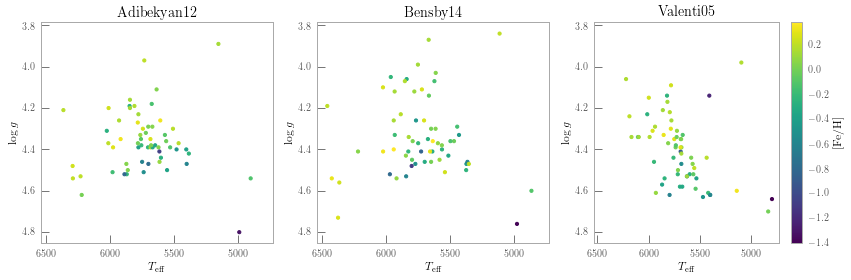

In [41]:
# Plot the H-R diagram of labels from various surveys, and the inferred latent variables
xi, yi, zi = range(3)

z = np.hstack([
    y[:, :, zi].flatten(), 
    (p_opt["X"][:, zi] * scales[zi] + mu[zi]).flatten()
])

kwds = dict(vmin=np.nanmin(z), vmax=np.nanmax(z),
            s=10, cmap="viridis")

K = M
fig, axes = plt.subplots(1, K, figsize=(4 * K, 4))

for m, ax in enumerate(axes[:M]):
    scat = ax.scatter(
        y[:, m, xi], 
        y[:, m, yi], 
        c=y[:, m, zi], **kwds)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"\textrm{{{0}}}".format(survey_reference))

xlimits = np.hstack([ax.get_xlim() for ax in axes])
ylimits = np.hstack([ax.get_ylim() for ax in axes])

xlimits = (np.max(xlimits), np.min(xlimits))
ylimits = (np.max(ylimits), np.min(ylimits))

for ax in axes:
    ax.set_xlabel(latex_label_names[xi])
    ax.set_ylabel(latex_label_names[yi])
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)
    
cbar = plt.colorbar(scat)
cbar.set_label(latex_label_names[zi])

fig.tight_layout()


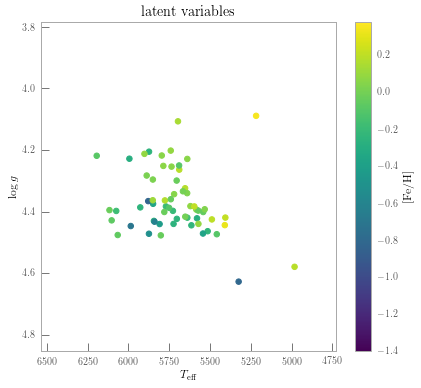

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))

kwds.update(s=30)
scat = ax.scatter(X[:, xi], X[:, yi], c=X[:, zi], **kwds)
cbar = plt.colorbar(scat)
cbar.set_label(latex_label_names[zi])

ax.set_xlabel(latex_label_names[xi])
ax.set_ylabel(latex_label_names[yi])
ax.set_ylim(ylimits)
ax.set_xlim(xlimits)

ax.set_title(r"\textrm{latent variables}")

fig.tight_layout()

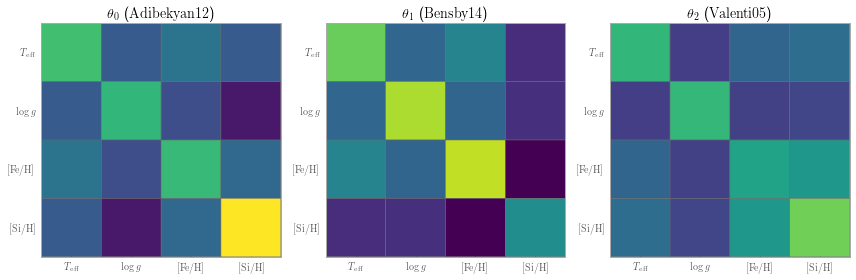

In [46]:
# Plot the theta coefficients for each survey.
fig, axes = plt.subplots(1, M, figsize=(4 * M, 4))

kwds = dict(cmap="viridis", edgecolors="#666666", linewidths=0.5,
            vmin=np.min(p_opt["theta"]), vmax=np.max(p_opt["theta"]))

for m, ax in enumerate(axes):
    theta = p_opt["theta"][m]
    ax.pcolor(theta.T, **kwds)
    
    survey_reference = survey_data_paths[m].split("/")[1].split("-")[0]
    ax.set_title(r"$\theta_{{{0}}}$ (\textrm{{{1}}})".format(m, survey_reference))
    ax.set_xticks(0.5 + np.arange(D))
    ax.set_yticks(0.5 + np.arange(D))
    ax.set_xticklabels(latex_label_names)
    ax.set_yticklabels(latex_label_names)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    
fig.tight_layout()

In [28]:
print(kwds)

{'cmap': 'viridis', 'edgecolors': '#666666', 'linewidths': 0.5, 'vmin': -0.603221799217974, 'vmax': 2.184626317143877}


(61, 3, 4)


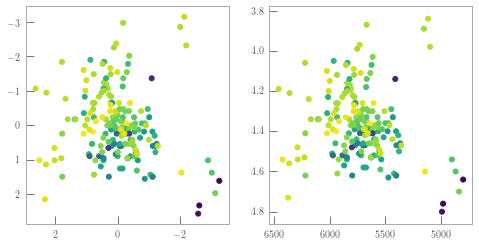

In [29]:
print(data["y"].shape)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

y0 = data["y"].reshape((-1, D))
y1 = y0 * scales + mu

axes[0].scatter(y0[:, 0],
                y0[:, 1],
                c=y0[:, 2])

axes[1].scatter(y1[:, 0],
                y1[:, 1],
                c=y1[:, 2])

for ax in axes:
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylim(ax.get_ylim()[::-1])

In [55]:
data

{'D': 4,
 'M': 3,
 'N': 61,
 'scales': array([1., 1., 1., 1.]),
 'y': array([[[ 9.23449926e-01,  8.40513360e-01, -2.37654956e-01,
          -5.24497094e-01],
         [ 7.63739537e-01, -2.28876755e-01, -2.65877446e-01,
           2.23331088e-01],
         [ 8.20525453e-01,  5.43460550e-01, -3.50544916e-01,
          -5.55656602e-01]],
 
        [[ 1.08316031e+00, -3.47697879e-01, -5.19879855e-01,
          -7.65983278e-01],
         [ 8.73762249e-01, -1.89237249e+00, -4.06989895e-01,
           2.62280473e-01],
         [ 1.05476736e+00, -8.22982374e-01, -4.91657365e-01,
          -7.89352909e-01]],
 
        [[-4.18117336e-01,  4.24639426e-01, -5.19879855e-01,
          -8.82831432e-01],
         [-5.45885646e-01,  1.86997179e-01, -4.63434875e-01,
           2.62280473e-01],
         [-4.14568216e-01,  8.99923922e-01, -5.19879855e-01,
          -7.89352909e-01]],
 
        [[-2.58406948e-01,  6.81760547e-02, -6.89214795e-01,
          -6.37450309e-01],
         [-2.79701666e-01,  2.46

In [ ]:
# Plot the \sigma values for each survey.
